In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

 

In [12]:
cars = pd.read_csv('cars.csv')
x = cars[['wt', 'disp']]
y = cars['mpg']  # 1D Series; easier to compute with




Text(0.5, 1.0, 'Scatterplot of mpg vs wt')

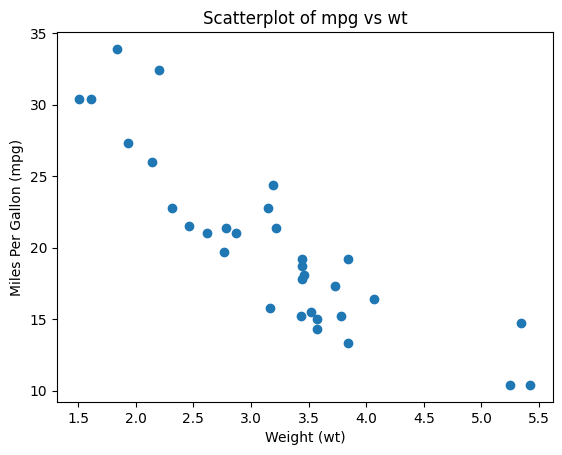

In [9]:
plt.scatter(cars['wt'], cars['mpg'])
plt.xlabel('Weight (wt)')
plt.ylabel('Miles Per Gallon (mpg)')
plt.title('Scatterplot of mpg vs wt')

Text(0.5, 1.0, 'Scatterplot of mpg vs disp')

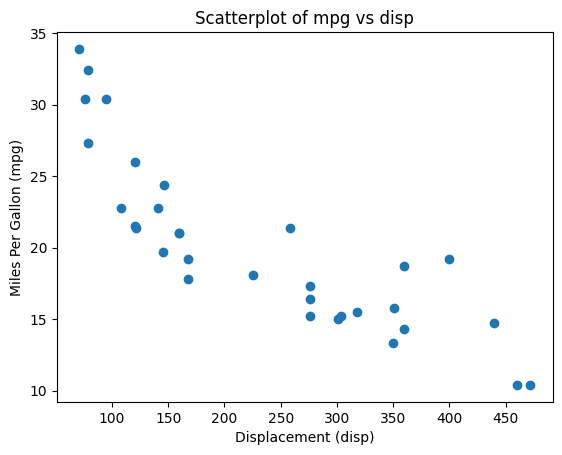

In [10]:
# We will perform gradient descent on displacement, but not weight. 

plt.scatter(cars['disp'], cars['mpg'])
plt.xlabel('Displacement (disp)')
plt.ylabel('Miles Per Gallon (mpg)')
plt.title('Scatterplot of mpg vs disp')

In [19]:
def get_data_mat(X):
    # Adds intercept column of ones on the left 
    ones = np.ones(X.shape[0]).reshape(-1, 1)
    data_mat = np.concatenate((ones, X), axis=1)
    return data_mat
    
def predict(w, X):
    data_mat = get_data_mat(X)
    pred = np.dot(data_mat, w)
    return pred

def get_loss(w, X, y):
    """
    Mean Squared Error (MSE) = average of squared differences
    between predictions and actual targets.
    """
    y_hat = predict(w, X)                 # predictions (shape: n,)
    # Ensure y is a 1D array for subtraction
    y_vec = np.asarray(y).reshape(-1)     
    return np.mean((y_hat - y_vec)**2)


In [20]:
def get_gradient(w, X, y):
    """
    Gradient of the MSE loss with respect to weights w.
    Uses the matrix formula: (2/n) * X^T * (Xw - y).
    """
    X_aug = get_data_mat(X)               # add intercept column
    y_hat = X_aug @ w                     # predictions
    y_vec = np.asarray(y).reshape(-1)
    residuals = y_hat - y_vec             # (Xw - y)
    n = X_aug.shape[0]
    return (2.0 / n) * (X_aug.T @ residuals)


In [21]:
def perform_gradient_descent(X, y, eta, num_iters):

    w_init = np.random.normal(loc=0.0, scale=0.1, size= X.shape[1] + 1)   
    w = [w_init]
    
    loss_init = get_loss(w_init, X, y)
    loss = [loss_init]


    #for a fixed number of iterations
    for i in range(num_iters):
        grad = get_gradient(w[-1], X, y)

        #travel in the direction opposite the gradient
        w_new = w[-1] - eta*grad
        loss_new = get_loss(w_new, X, y)

        w.append(w_new)
        loss.append(loss_new)
        
    return w, loss 

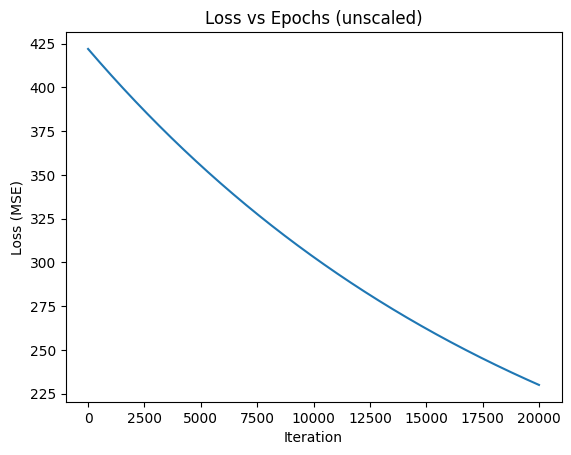

Final weights (intercept, wt, disp): [0.58066924 1.9947974 ]


In [22]:
w_hist, loss_hist = perform_gradient_descent(x, y, eta=1e-6, num_iters=20000)

plt.plot(loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.title("Loss vs Epochs (unscaled)")
plt.show()

print("Final weights (intercept, wt, disp):", w_hist[-1])


In [24]:
def sigmoid(z):
    # safe sigmoid
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def bin_cross_entropy(y_true, y_prob, eps=1e-12):
    # y_true in {0,1}, y_prob in (0,1)
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

# ---------- Preprocessing ----------
def center_only(X):
    mean_ = X.mean(axis=0, keepdims=True)
    return X - mean_, mean_, None

def standardize(X):
    mean_ = X.mean(axis=0, keepdims=True)
    std_ = X.std(axis=0, ddof=0, keepdims=True)
    std_[std_ == 0] = 1.0
    return (X - mean_) / std_, mean_, std_

def apply_transform(X, mean_, std_):
    if std_ is None:  # only centered
        return X - mean_
    out = (X - mean_) / std_
    out[:, std_.ravel() == 0] = 0.0
    return out

In [25]:
def fit_logreg_single_no_intercept(x, y, lr=0.1, epochs=1000, center=True, scale=False):
    """
    x: shape (n_samples,) or (n_samples, 1)
    y: shape (n_samples,) in {0,1}
    Returns: w (float), history (list of losses), transform params
    """
    x = x.reshape(-1, 1).astype(float)
    y = y.astype(float).ravel()

    # Center vs scale (target is NOT transformed)
    if scale:
        x_t, mean_, std_ = standardize(x)
    elif center:
        x_t, mean_, std_ = center_only(x)
    else:
        x_t, mean_, std_ = x.copy(), np.zeros((1,1)), None

    # Parameter (single weight, no intercept)
    w = np.random.randn() * 0.01
    history = []

    for _ in range(epochs):
        z = x_t.ravel() * w
        p = sigmoid(z)
        loss = bin_cross_entropy(y, p)
        history.append(loss)

        # Gradient: dL/dw = mean((p - y) * x)
        grad = np.mean((p - y) * x_t.ravel())
        w -= lr * grad

    return w, history, (mean_, std_)

def predict_proba_single_no_intercept(x, w, transform_params):
    mean_, std_ = transform_params
    x = x.reshape(-1, 1).astype(float)
    x_t = apply_transform(x, mean_, std_)
    return sigmoid(x_t.ravel() * w)

def plot_loss(history, title="Loss"):
    plt.figure()
    plt.plot(history)
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy")
    plt.title(title)
    plt.show()


In [26]:
def fit_logreg_multi_with_intercept(X, y, lr=0.1, epochs=1000, center=True, scale=False):
    """
    X: (n_samples, n_features)
    y: (n_samples,) in {0,1}
    Returns: beta ((d+1,)), history (list), transform params
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).ravel()

    if scale:
        X_t, mean_, std_ = standardize(X)
    elif center:
        X_t, mean_, std_ = center_only(X)
    else:
        X_t, mean_, std_ = X.copy(), np.zeros((1, X.shape[1])), None

    # Add intercept column of ones
    n, d = X_t.shape
    X_design = np.hstack([np.ones((n, 1)), X_t])

    beta = np.random.randn(d + 1) * 0.01
    history = []

    for _ in range(epochs):
        z = X_design @ beta
        p = sigmoid(z)
        loss = bin_cross_entropy(y, p)
        history.append(loss)

        # Vectorized gradient: (1/n) * X^T (p - y)
        grad = (X_design.T @ (p - y)) / n
        beta -= lr * grad

    return beta, history, (mean_, std_)

def predict_proba_multi_with_intercept(X, beta, transform_params):
    mean_, std_ = transform_params
    X = np.asarray(X, dtype=float)
    X_t = apply_transform(X, mean_, std_)
    X_design = np.hstack([np.ones((X_t.shape[0], 1)), X_t])
    return sigmoid(X_design @ beta)


In [27]:
from sklearn import datasets

def load_iris_binary(feature_indices=None, classes=(0,1)):
    """
    Returns X, y for a binary iris task.
    classes: pick two class indices from {0,1,2} (0=setosa, 1=versicolor, 2=virginica)
    feature_indices: list of feature column indices to keep (e.g., [0] or [0,2])
    """
    iris = datasets.load_iris()
    X = iris.data
    y_raw = iris.target
    mask = np.isin(y_raw, classes)
    X = X[mask]
    y_raw = y_raw[mask]
    # map to 0/1
    y = (y_raw == classes[1]).astype(float)
    if feature_indices is not None:
        X = X[:, feature_indices]
    return X, y

def load_penguins_binary():
    """
    Tries to load penguins via seaborn.
    Returns X, y (flipper_length_mm, bill_length_mm, etc.). If seaborn missing, returns None, None.
    Binary task: Adelie (0) vs Gentoo (1); drops NaNs.
    """
    try:
        import seaborn as sns
        df = sns.load_dataset("penguins")
    except Exception:
        return None, None

    df = df.dropna(subset=["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"])
    df = df[df["species"].isin(["Adelie", "Gentoo"])].copy()
    y = (df["species"] == "Gentoo").astype(float).to_numpy()
    X = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]].to_numpy()
    return X, y


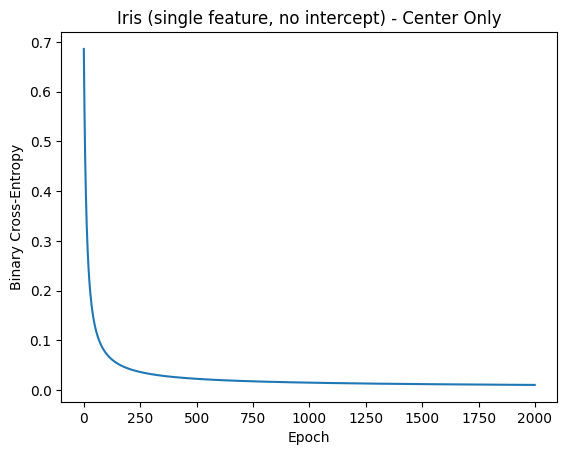

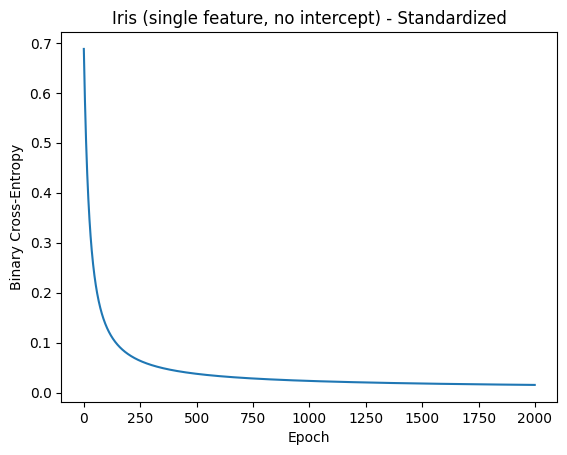

Accuracy (center only): 1.0
Accuracy (standardized): 1.0


In [28]:
# Iris: classify Setosa (0) vs Versicolor (1) using a single feature (e.g., petal length index=2)
X1, y1 = load_iris_binary(feature_indices=[2], classes=(0,1))  # petal length only
x1 = X1.ravel()

# Center only
w_c, hist_c, tf_c = fit_logreg_single_no_intercept(x1, y1, lr=0.1, epochs=2000, center=True, scale=False)
plot_loss(hist_c, title="Iris (single feature, no intercept) - Center Only")

# Scale (standardize)
w_s, hist_s, tf_s = fit_logreg_single_no_intercept(x1, y1, lr=0.1, epochs=2000, center=False, scale=True)
plot_loss(hist_s, title="Iris (single feature, no intercept) - Standardized")

# Quick accuracy check
def accuracy(y_true, y_prob, thresh=0.5):
    return np.mean((y_prob >= thresh) == y_true)

p_c = predict_proba_single_no_intercept(x1, w_c, tf_c)
p_s = predict_proba_single_no_intercept(x1, w_s, tf_s)
print("Accuracy (center only):", accuracy(y1, p_c))
print("Accuracy (standardized):", accuracy(y1, p_s))


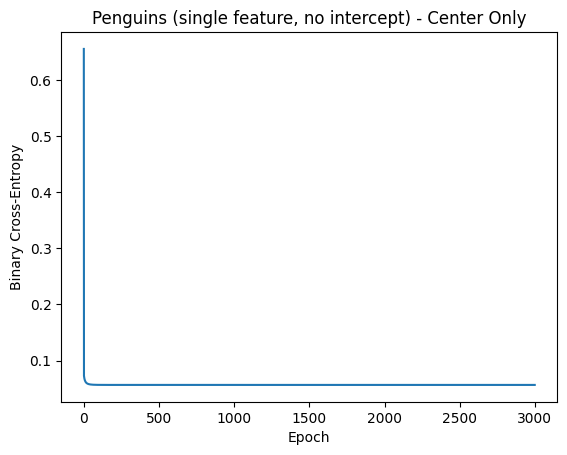

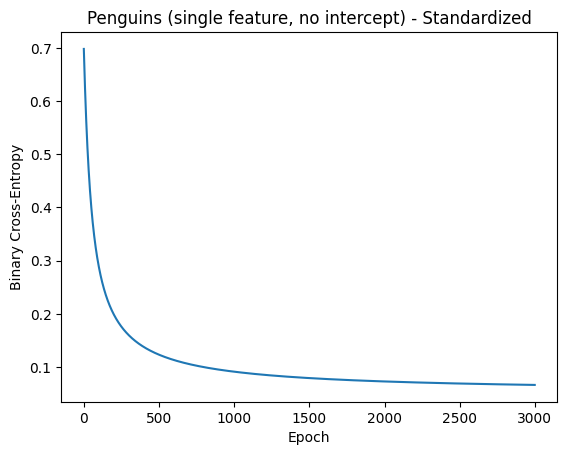

Penguins Accuracy (center only): 0.9854014598540146
Penguins Accuracy (standardized): 0.9854014598540146


In [29]:
Xp, yp = load_penguins_binary()
if Xp is not None:
    # try single feature: flipper_length_mm (index=2)
    x_peng = Xp[:, 2]

    w_pc, hist_pc, tf_pc = fit_logreg_single_no_intercept(x_peng, yp, lr=0.05, epochs=3000, center=True, scale=False)
    plot_loss(hist_pc, title="Penguins (single feature, no intercept) - Center Only")

    w_ps, hist_ps, tf_ps = fit_logreg_single_no_intercept(x_peng, yp, lr=0.05, epochs=3000, center=False, scale=True)
    plot_loss(hist_ps, title="Penguins (single feature, no intercept) - Standardized")

    print("Penguins Accuracy (center only):", accuracy(yp, predict_proba_single_no_intercept(x_peng, w_pc, tf_pc)))
    print("Penguins Accuracy (standardized):", accuracy(yp, predict_proba_single_no_intercept(x_peng, w_ps, tf_ps)))
else:
    print("Seaborn not available or penguins dataset unavailable; skipping penguins single-feature run.")


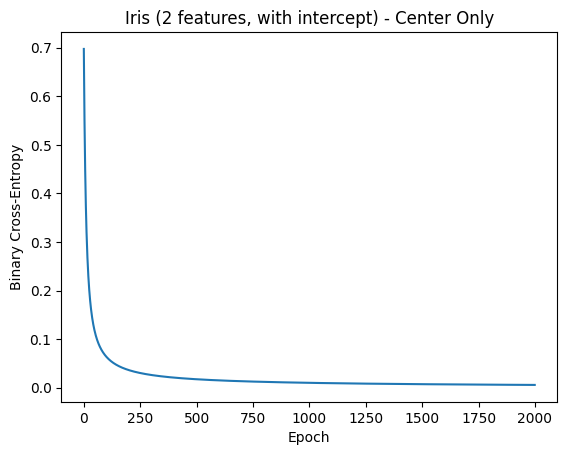

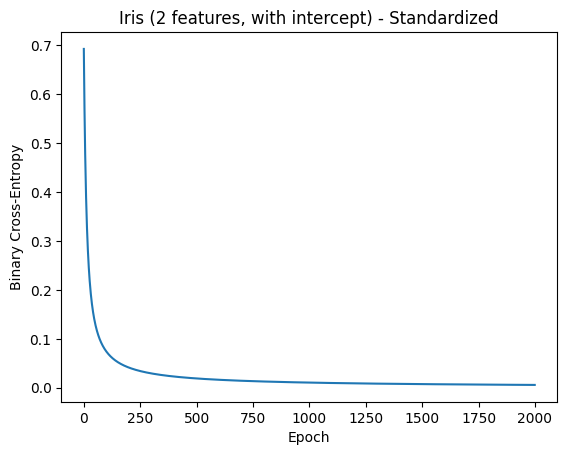

Iris 2-feat Acc (center only): 1.0
Iris 2-feat Acc (standardized): 1.0


In [30]:
# Use 2 features (e.g., petal length=2, petal width=3)
X2, y2 = load_iris_binary(feature_indices=[2,3], classes=(0,1))

# Center only
beta_c2, hist_c2, tf_c2 = fit_logreg_multi_with_intercept(X2, y2, lr=0.1, epochs=2000, center=True, scale=False)
plot_loss(hist_c2, title="Iris (2 features, with intercept) - Center Only")

# Scale
beta_s2, hist_s2, tf_s2 = fit_logreg_multi_with_intercept(X2, y2, lr=0.1, epochs=2000, center=False, scale=True)
plot_loss(hist_s2, title="Iris (2 features, with intercept) - Standardized")

print("Iris 2-feat Acc (center only):", accuracy(y2, predict_proba_multi_with_intercept(X2, beta_c2, tf_c2)))
print("Iris 2-feat Acc (standardized):", accuracy(y2, predict_proba_multi_with_intercept(X2, beta_s2, tf_s2)))


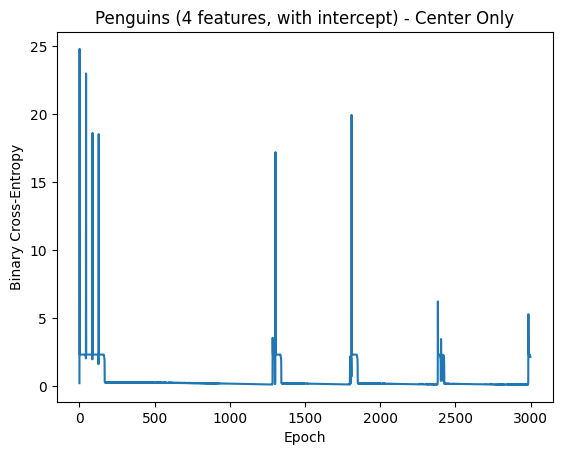

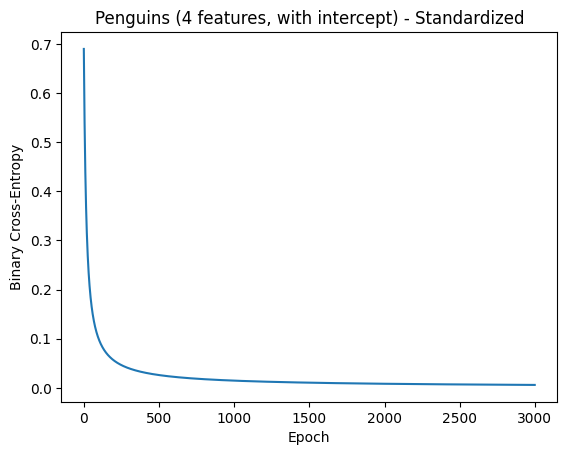

Penguins 4-feat Acc (center only): 0.9233576642335767
Penguins 4-feat Acc (standardized): 1.0


In [31]:
Xp, yp = load_penguins_binary()
if Xp is not None:
    beta_pc, hist_pc, tf_pc = fit_logreg_multi_with_intercept(Xp, yp, lr=0.05, epochs=3000, center=True, scale=False)
    plot_loss(hist_pc, title="Penguins (4 features, with intercept) - Center Only")

    beta_ps, hist_ps, tf_ps = fit_logreg_multi_with_intercept(Xp, yp, lr=0.05, epochs=3000, center=False, scale=True)
    plot_loss(hist_ps, title="Penguins (4 features, with intercept) - Standardized")

    print("Penguins 4-feat Acc (center only):", accuracy(yp, predict_proba_multi_with_intercept(Xp, beta_pc, tf_pc)))
    print("Penguins 4-feat Acc (standardized):", accuracy(yp, predict_proba_multi_with_intercept(Xp, beta_ps, tf_ps)))
else:
    print("Seaborn not available or penguins dataset unavailable; skipping penguins multi-feature run.")
